In [15]:
from gtda.time_series import SlidingWindow,PearsonDissimilarity
from gtda.homology import VietorisRipsPersistence
from gtda.diagrams import PersistenceLandscape
import numpy as np
import pandas as pd
import os
import mne
from mne.io import concatenate_raws, read_raw_edf
from gtda.pipeline import make_pipeline
from gtda.time_series import  SlidingWindow
from gtda.homology import VietorisRipsPersistence
from gtda.time_series import TakensEmbedding
from gtda.diagrams import BettiCurve
from sklearn.model_selection import train_test_split, RepeatedKFold, KFold, GroupKFold
from sklearn.linear_model import LogisticRegression as LR
from sklearn.neural_network import MLPClassifier as MLP
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.metrics import classification_report, roc_auc_score,confusion_matrix,precision_score,cohen_kappa_score,f1_score, accuracy_score
from gtda.diagrams import PersistenceImage
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import matplotlib as mpl
import warnings
import pickle
import seaborn as sns
from tqdm import tqdm
from time import time
import copy
warnings.filterwarnings("ignore")

## 数据预处理及特征生成

#### 基地址

In [2]:
dataset_dir = "./MAC_Dataset/physionet.org/files/eegmat/1.0.0"
feature_dir = "./fea_pkl"

#### 所有的数据文件列表

In [3]:
file_list = []
with open(os.path.join(dataset_dir, "RECORDS"), "r") as f:
    file_list = f.readlines()
file_list

['Subject00_1.edf\n',
 'Subject00_2.edf\n',
 'Subject01_1.edf\n',
 'Subject01_2.edf\n',
 'Subject02_1.edf\n',
 'Subject02_2.edf\n',
 'Subject03_1.edf\n',
 'Subject03_2.edf\n',
 'Subject04_1.edf\n',
 'Subject04_2.edf\n',
 'Subject05_1.edf\n',
 'Subject05_2.edf\n',
 'Subject06_1.edf\n',
 'Subject06_2.edf\n',
 'Subject07_1.edf\n',
 'Subject07_2.edf\n',
 'Subject08_1.edf\n',
 'Subject08_2.edf\n',
 'Subject09_1.edf\n',
 'Subject09_2.edf\n',
 'Subject10_1.edf\n',
 'Subject10_2.edf\n',
 'Subject11_1.edf\n',
 'Subject11_2.edf\n',
 'Subject12_1.edf\n',
 'Subject12_2.edf\n',
 'Subject13_1.edf\n',
 'Subject13_2.edf\n',
 'Subject14_1.edf\n',
 'Subject14_2.edf\n',
 'Subject15_1.edf\n',
 'Subject15_2.edf\n',
 'Subject16_1.edf\n',
 'Subject16_2.edf\n',
 'Subject17_1.edf\n',
 'Subject17_2.edf\n',
 'Subject18_1.edf\n',
 'Subject18_2.edf\n',
 'Subject19_1.edf\n',
 'Subject19_2.edf\n',
 'Subject20_1.edf\n',
 'Subject20_2.edf\n',
 'Subject21_1.edf\n',
 'Subject21_2.edf\n',
 'Subject22_1.edf\n',
 'Subject2

In [4]:
# subject-info.csv

####  用户数据迭代器函数

In [4]:
def next_subject_data(status=1):
    """
    status:[1,2] 1: rest, 2: test
    return: sub_id, status_id, data
    """
    for fname in file_list:
        fname = str(fname).strip()
        subject, status_ = fname.split(".")[0].split("_")
        sub_id = int(subject[-2:])
        status_id = int(status_) # 1表示rest， 2表示test（during）
        if status_id != status:
            continue
        raw=read_raw_edf(os.path.join(dataset_dir, fname),preload=False)
        eeg = raw.to_data_frame()
        eeg = eeg[['EEG Fp1','EEG Fp2','EEG F3','EEG F4','EEG F7','EEG F8',
                   'EEG T3','EEG T4','EEG C3','EEG C4','EEG T5','EEG T6',
                   'EEG P3','EEG P4','EEG O1','EEG O2','EEG Fz','EEG Cz','EEG Pz']]
        #cut_off_len = 90000 if status_id == 2 else 30000
        cut_off_len = 30000 # 最后1000摒弃
        data = eeg.values[:cut_off_len, :] # 91000 * 19,最后1000摒弃
        yield sub_id, status_id, data


#### 拓扑特征(网络连接)计算

In [5]:
def gtda(data, sliding_win=2, stride=2, fs=500):
    """
    网络连接的方式
    data: raw dataset
    sliding win: to represent sliding window with secod 
    overlap win: to represent overlap window with second
    """
    sliding_samples = int(sliding_win * fs)
    stride = int(stride * fs)
    step = [
        SlidingWindow(size=sliding_samples,stride=stride),
        PearsonDissimilarity(absolute_value=True),
        VietorisRipsPersistence(metric='precomputed'),
        PersistenceLandscape()
    ]
    tda = make_pipeline(*step).fit_transform(data)
    return np.reshape(tda,newshape=(-1,tda.shape[1]*tda.shape[2]))

#### 拓扑特征（点云）计算

In [7]:
def topo_feature(data, time_delay, stride, dimension):
    featuress = []
    #for i in tqdm(range(data.shape[-1])):
    #data_ = data[:, i].reshape(-1, 1)
    data_ = data[:500,:].reshape(19,-1)
    print(data_.shape)
    """
    # Takens 延时嵌入 构造点云
    TE = TakensEmbedding(time_delay=time_delay, stride=1, dimension=dimension, flatten=True)
    point_cloud = TE.fit_transform(data_)
    # 对点云 计算持续同调 Persistence diagrams，来源于这种方法Vietoris–Rips filtrations，metric不能是precomputed
    VR = VietorisRipsPersistence(
        metric="euclidean",
        homology_dimensions=[0, 1, 2],
        #-1表示使用处理器全部内核
        n_jobs=-1,
        # 这个参数还不懂，参考DOI： https://doi.org/10.4230/LIPIcs.SoCG.2020.19
        collapse_edges=True)
    VRs = VR.fit_transform(point_cloud)
    # 计算 Betti curves <betti_curve>` of persistence diagrams
    # n_bins: The number of filtration parameter values, per available homology
    # dimension
    BE = BettiCurve(n_bins=100, n_jobs=-1)
    feature = BE.fit_transform(VRs)
    """
    step = [
        TakensEmbedding(time_delay=time_delay, stride=stride, dimension=dimension, flatten=True),
        VietorisRipsPersistence(metric="euclidean",homology_dimensions=[0, 1, 2], n_jobs=-1,collapse_edges=True),
        BettiCurve(n_bins=100, n_jobs=-1),
        #PersistenceLandscape(n_layers=1, n_bins=100, n_jobs=-1)
    ]
    feature = make_pipeline(*step).fit_transform(data_)
    
    print(feature.shape)
    feature = feature.mean(axis=1)
    print(feature.shape)
    featuress.append(feature)
    #break
    #featuress = np.concatenate(featuress, axis=1)
    return featuress

In [13]:
start = time.time()
for sub_id, status_id, data in next_subject_data(status=1):
    topo_feature(data, time_delay=5, stride=10, dimension=20)
    break
print(f"耗时{time.time()-start}s")

Extracting EDF parameters from /home/data1/maliang/EEG_related/MAC/MAC_Dataset/physionet.org/files/eegmat/1.0.0/Subject00_1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
(19, 500)
(19, 3, 100)
(19, 100)
耗时1.8002231121063232s


#### 计算并保存特征

In [12]:
def pickle_obj(X, path, fname):
    with open(os.path.join(path, "{}.pkl".format(fname)), "wb") as f:
        pickle.dump(X, f)
        
def gen_feature(raw_data, path, fname, sliding_win, stride):
    """
    raw_data: raw_data 
    path: [DMAC, QMAC]
    fname: sub_id
    sliding_win:
    stride:
    """
    fea = gtda(raw_data, sliding_win=sliding_win, stride=stride)
    #print(fea.shape)
    pickle_obj(fea, path=os.path.join(feature_dir, path), fname="S_{}".format(fname))

#### 更新DMAC数据集特征

In [13]:
def update_sample(sliding_win=1, stride=0.5):
    # 为rest提取特征
    print(f"滑动窗口{sliding_win}s, 步长{stride}s")
    for sub_id, status_id, data in next_subject_data(status=1):
        gen_feature(data, "DMAC/rest", sub_id, sliding_win, stride)
    # 为test提取特征
    print(f"滑动窗口{sliding_win}s, 步长{stride}s")
    for sub_id, status_id, data in next_subject_data(status=2):
        gen_feature(data, "DMAC/test", sub_id, sliding_win, stride)

* 测试

In [46]:
update_sample(sliding_win=2, stride=1)

滑动窗口2s, 步长1s
Extracting EDF parameters from /home/data1/maliang/EEG_related/MAC/MAC_Dataset/physionet.org/files/eegmat/1.0.0/Subject00_1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
(59, 200)
Extracting EDF parameters from /home/data1/maliang/EEG_related/MAC/MAC_Dataset/physionet.org/files/eegmat/1.0.0/Subject01_1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
(59, 200)
Extracting EDF parameters from /home/data1/maliang/EEG_related/MAC/MAC_Dataset/physionet.org/files/eegmat/1.0.0/Subject02_1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
(59, 200)
Extracting EDF parameters from /home/data1/maliang/EEG_related/MAC/MAC_Dataset/physionet.org/files/eegmat/1.0.0/Subject03_1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
(59, 200)
Extracting EDF parameters from /home/data1/maliang/EEG_related/MAC/MAC_Dataset/physionet.or

KeyboardInterrupt: 

## 两种任务，两种交叉验证方法
  * 任务1. DMAC任务
  * 任务2. QMAC任务
  * CV1. subject-wise
  * CV2. leave-one-subject-out

# DMAC 

### INTRA_SUBJECT

In [7]:
def Kfold_validation(classifier,sample_pwi, label_pwi,groups, sw=1,task='binary', sub="666", path="mixed_sub_rs", show_cm=1, repeats=10):
    """
    """
    results = np.zeros((repeats*5, 7))
    gkf = GroupKFold(n_splits=5)
    #kf = RepeatedKFold(n_splits=5, n_repeats=repeats, random_state=666)
    for idx, train_test_index in enumerate(gkf.split(sample_pwi,label_pwi, groups)):
        #print("TRAIN",train_test_index[0])
        #print("TRAIN",train_test_index[1])
        x_train, y_train, x_test, y_test = sample_pwi[train_test_index[0]], label_pwi[train_test_index[0]], sample_pwi[train_test_index[1]], label_pwi[train_test_index[1]]
        classifier.fit(x_train, y_train)
        y_pred = classifier.predict(x_test)
        y_prob = classifier.predict_proba(x_test)[:,1]
        if show_cm:
            cf_matrix = confusion_matrix(y_test, y_pred, normalize="true")
            lables_name = ["low", "high"] if task=='binary' else ["lo","mi", "hi"]
            title_name = "objective binary task" if task=="binary" else "subjective tenary task"
            draw_confusion_matrix(cf_matrix, label_names=lables_name, name=title_name)
            #draw_confusion_matrix(cf_matrix, ["low", "high"], "sub{} pw{} of {} task".format(sub, pw_level, path.split("_")[0]))
            show_cm = 0
        cohen_kappa_s = cohen_kappa_score(y_test, y_pred)
        acc = accuracy_score(y_test, y_pred, normalize=True, sample_weight=None)
        roc_score = roc_auc_score(y_test, y_prob, average="micro", multi_class="ovr")
        micro_precision_s = precision_score(y_test, y_pred, average="micro")
        macro_precision_s = precision_score(y_test, y_pred, average="macro")
        weight_precision_s = precision_score(y_test, y_pred, average="weighted")
        f1 = f1_score(y_test, y_pred, average="micro")
        results[idx, :] = roc_score, cohen_kappa_s, micro_precision_s, macro_precision_s, weight_precision_s, f1, acc
    np.savetxt(f"./all_result/{path}/{str(sw)}/S{sub}_rs.csv", results, delimiter=",", fmt="%10.5f")  

In [8]:
def draw_confusion_matrix(cm, label_names, name):
    sns.set()
    mpl.rcParams['font.sans-serif'] = 'Times New Roman'
    mpl.rcParams['axes.unicode_minus'] = False
    f, ax = plt.subplots()
    sns.heatmap(cm, annot=True, ax=ax)
    try:
        ax.set(xticklabels=label_names, yticklabels=label_names)
    except Exception as e:
        print("\n")
        print(e)
        print('\n')
        label_names = ['lo', "hi"]
        ax.set(xticklabels=label_names, yticklabels=label_names)
    ax.set_title('{}'.format(name), fontsize=16, fontweight='bold')
    ax.set_xlabel('Pred Class', fontsize=14, fontweight='bold')
    ax.set_ylabel('True Class', fontsize=14, fontweight='bold')

In [9]:
def DMAC_intra_subject(sw=1):
    for idx in range(0, 36):
        clf = RF()
        # clf = LR()
        # clf = KNN(n_jobs=-1)
        # clf = MLP()
        print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~我是分隔符~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
        TEST_dest_path = os.path.join(feature_dir, "DMAC/test")
        REST_dest_path = os.path.join(feature_dir, "DMAC/rest")
        # 拿到样本集
        test_sample_path = [TEST_dest_path, REST_dest_path]
        sample_last = np.zeros((0,200))
        out_fname = "S_{}.pkl".format(idx)
        for path in test_sample_path:
            with open(os.path.join(path, out_fname), "rb") as pkl_file:
                test_sample = pickle.load(pkl_file) 
                sample_last = np.concatenate((sample_last, test_sample), axis=0)

        samples = copy.deepcopy(sample_last)
        y_test = np.zeros((len(test_sample), 1))
        labels = np.concatenate(((y_test + 1), y_test), axis=0)
        n_samples = test_sample.shape[0]
        groups = np.zeros(n_samples)
        groups[:int(n_samples/5)] = 1
        groups[int(n_samples/5):int(n_samples*2/5)] = 2
        groups[int(n_samples*2/5):int(n_samples*3/5)] = 3
        groups[int(n_samples*3/5):int(n_samples*4/5)] = 4
        groups[int(n_samples*4/5):] = 5 
        groups = np.tile(groups, len(test_sample_path))
        print("subject{}数据集大小 sample: {}, label: {}".format(idx, samples.shape, labels.shape))
        start = time()
        Kfold_validation(clf, samples, labels, groups, sw=sw, task="binary", sub=idx, path="RF/DMAC/intra_subject", show_cm=0, repeats=1)
        end = time()
        print(f"{idx}: {round((end-start),4)}s")

In [16]:
for sw in range(1, 5):
    update_sample(sliding_win=sw, stride=sw/2)
    DMAC_intra_subject(sw)

滑动窗口1s, 步长0.5s
Extracting EDF parameters from /home/data1/maliang/EEG_related/MAC/MAC_Dataset/physionet.org/files/eegmat/1.0.0/Subject00_1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /home/data1/maliang/EEG_related/MAC/MAC_Dataset/physionet.org/files/eegmat/1.0.0/Subject01_1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /home/data1/maliang/EEG_related/MAC/MAC_Dataset/physionet.org/files/eegmat/1.0.0/Subject02_1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /home/data1/maliang/EEG_related/MAC/MAC_Dataset/physionet.org/files/eegmat/1.0.0/Subject03_1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /home/data1/maliang/EEG_related/MAC/MAC_Dataset/physionet.org/files/eegmat/1.0.0/Subject04_1.edf..

### LOSO

In [351]:
import copy

In [359]:
# objective binary classification， 
# 另一种模型选择的方法是使用LOSO，选一个人的作为测试集，其它人的作为训练集, 
# 这种方式，48个对象的数据均可以使用，因此，最终可以得到48组结果
def gen_objectiv_LOSO(out_sub_id=1):
    print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~我是分隔符~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
    TEST_dest_path = os.path.join(feature_dir, "DMAC/test")
    REST_dest_path = os.path.join(feature_dir, "DMAC/rest")
    # 拿到测试集
    test_sample_path = [TEST_dest_path, REST_dest_path]
    sample_last = np.zeros((0,200))
    out_fname = "S_{}.pkl".format(out_sub_id)
    for path in test_sample_path:
        with open(os.path.join(path, out_fname), "rb") as pkl_file:
            test_sample = pickle.load(pkl_file) 
            sample_last = np.concatenate((sample_last, test_sample), axis=0)

    x_test = copy.deepcopy(sample_last)
    y_test = np.zeros((len(test_sample), 1))
    y_test = np.concatenate(((y_test + 1), y_test), axis=0)
    
    print("得到测试集 leave sub {} out".format(out_fname))
    print("测试集大小 sample: {}, label: {}".format(x_test.shape, y_test.shape))
    #return
    # 拿到训练集
    def get_sample(cls="test"):
        dest_path = os.path.join(feature_dir, "DMAC/{}".format(cls))
        all_file = os.listdir(dest_path)
        lable = 1 if cls=="test" else 0
        all_file.remove(out_fname)
        sample_last = np.zeros((0, 200))
        for fname in all_file:
            with open(os.path.join(dest_path, fname), "rb") as pkl_file:
                sample_sub= pickle.load(pkl_file)
                sample_last = np.concatenate((sample_last, sample_sub), axis=0)
        return sample_last
    simkap_test_sample = get_sample("test")
    label_hi = np.zeros((len(simkap_test_sample), 1)) + 1
    rest_sample = get_sample("rest")
    label_lo = np.zeros((len(rest_sample), 1))
    sample = np.concatenate((simkap_test_sample, rest_sample), axis=0)
    label = np.concatenate((label_hi, label_lo), axis=0)
    print("得到训练集")
    print("训练集大小 sample: {}, label: {}".format(sample.shape, label.shape))
    return sample, label, x_test, y_test



In [360]:
# 开始LOSO训练，
# 每一个对象都要被OUT一次，所以最终会有48个结果
from sklearn.utils import shuffle
def DMAC_LOSO(sw=1):
    results = np.zeros((36, 6), dtype=float)
    for idx in range(0, 36):
        #classifier = RandomForestClassifier()
        # clf = LR(n_jobs=-1)
        #clf = KNN(n_jobs=-1)
        clf = MLP()
        x_train, y_train, x_test, y_test = gen_objectiv_LOSO(out_sub_id=idx)
        x_train, y_train = shuffle(x_train, y_train)
        x_test, y_test = shuffle(x_test, y_test)
        clf.fit(x_train,y_train)
        y_pred = clf.predict(x_test)
        cf_matrix = confusion_matrix(y_test, y_pred, normalize="true")
        draw_confusion_matrix(cf_matrix, ["low", "high"], "Arithmetic task")
        #print(classification_report(y_test,y_pred,digits=4))
        
        y_prob = clf.predict_proba(x_test)[:,1]

        cohen_kappa_s = cohen_kappa_score(y_test, y_pred)
        roc_score = roc_auc_score(y_test, y_prob)
        micro_precision_s = precision_score(y_test, y_pred, average="micro")
        macro_precision_s = precision_score(y_test, y_pred, average="macro")
        weight_precision_s = precision_score(y_test, y_pred, average="weighted")
        f1 = f1_score(y_test, y_pred, average="micro")
        results[idx-1, :] = roc_score, cohen_kappa_s, micro_precision_s, macro_precision_s, weight_precision_s, f1
    np.savetxt("./all_result/DMAC/{}/{}/out.csv".format("LOSO", str(sw)), results, delimiter=",", fmt="%10.5f")

滑动窗口1s, 步长0.5s
Extracting EDF parameters from /home/amax/Data/Maliang/EEG_related/MAC/MAC_Dataset/physionet.org/files/eegmat/1.0.0/Subject00_1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /home/amax/Data/Maliang/EEG_related/MAC/MAC_Dataset/physionet.org/files/eegmat/1.0.0/Subject01_1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /home/amax/Data/Maliang/EEG_related/MAC/MAC_Dataset/physionet.org/files/eegmat/1.0.0/Subject02_1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /home/amax/Data/Maliang/EEG_related/MAC/MAC_Dataset/physionet.org/files/eegmat/1.0.0/Subject03_1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /home/amax/Data/Maliang/EEG_related/MAC/MAC_Dataset/physionet.org/files/eegmat/1.0

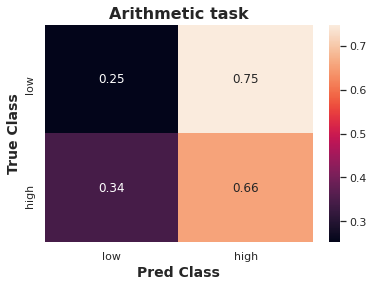

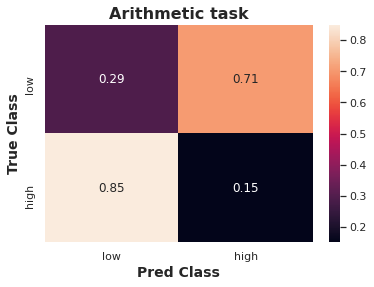

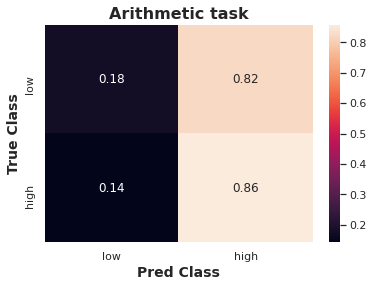

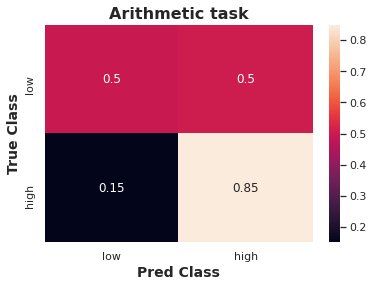

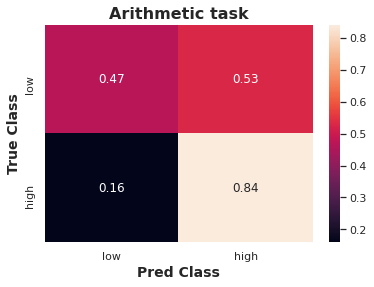

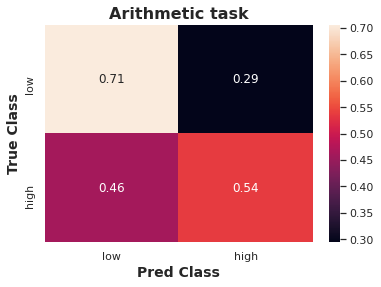

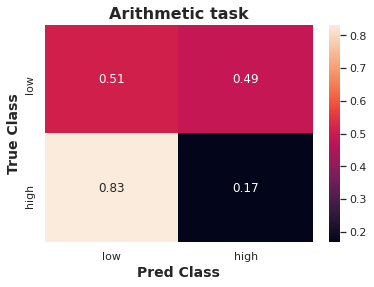

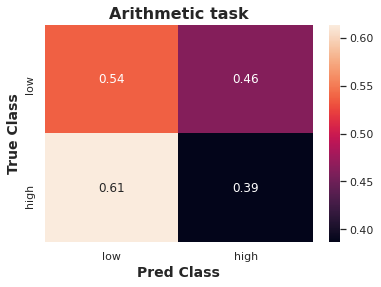

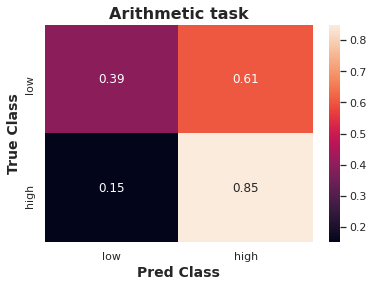

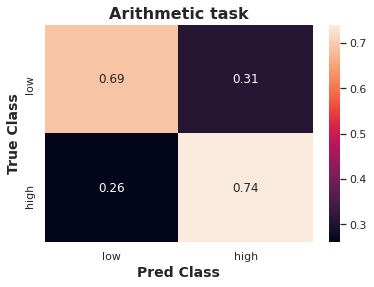

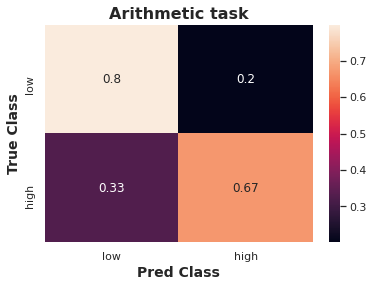

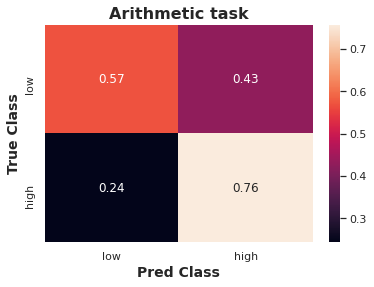

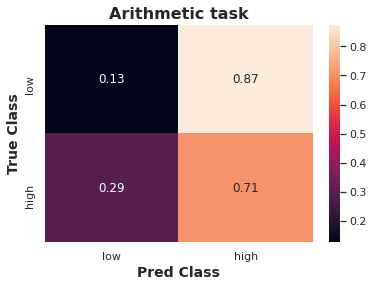

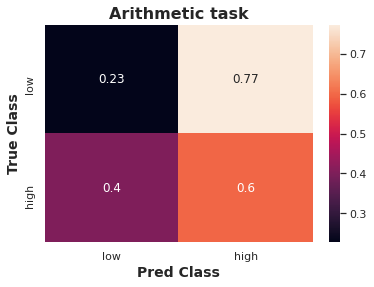

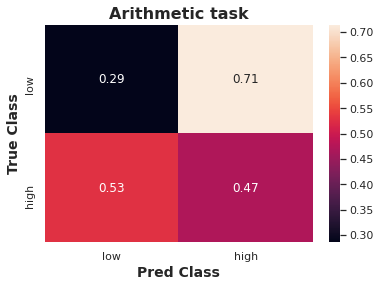

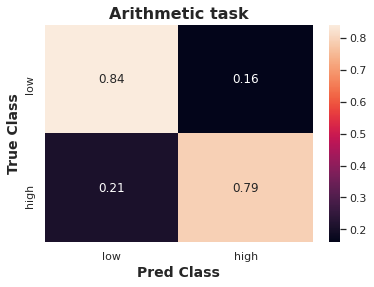

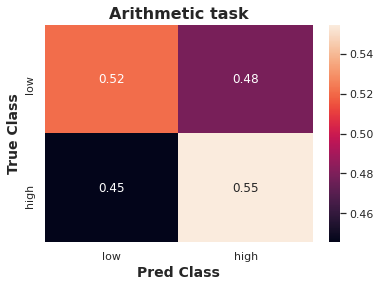

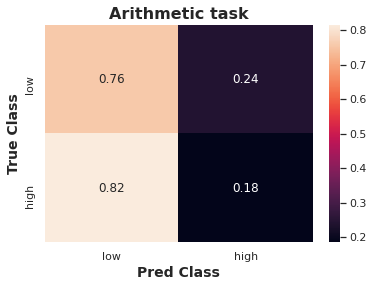

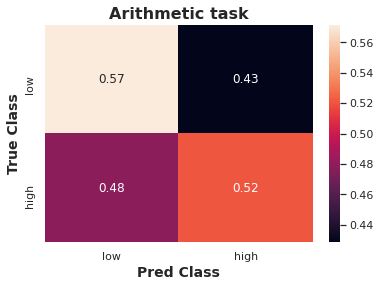

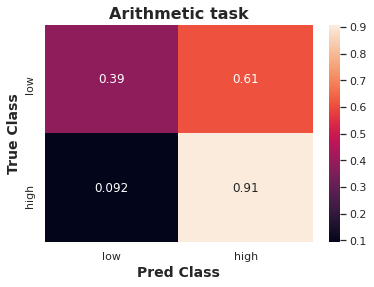

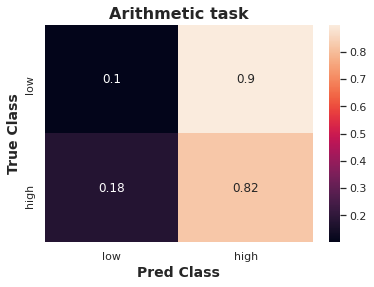

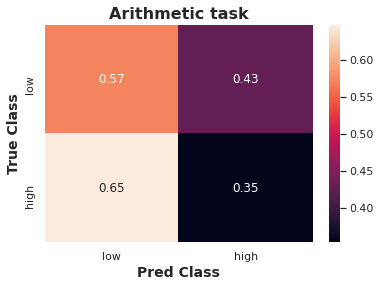

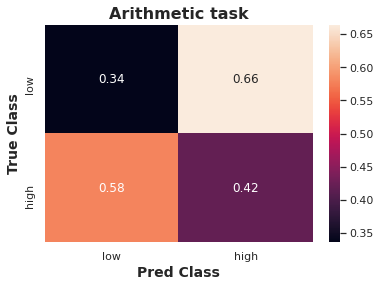

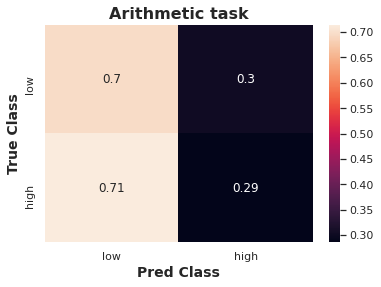

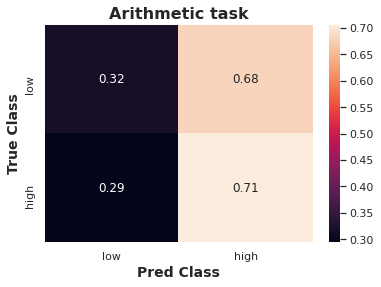

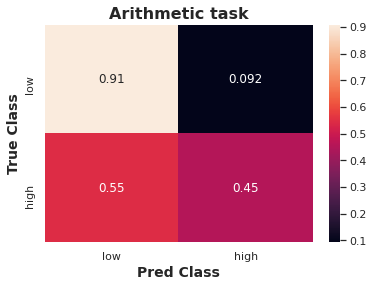

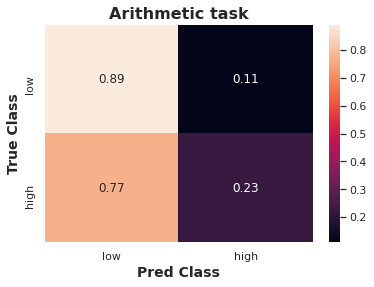

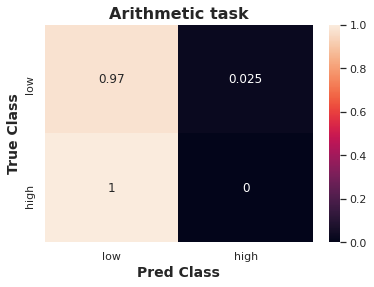

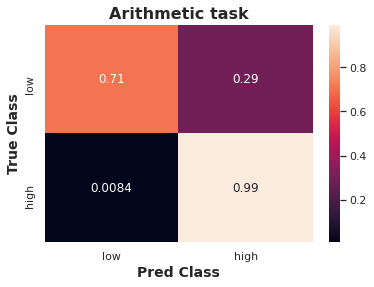

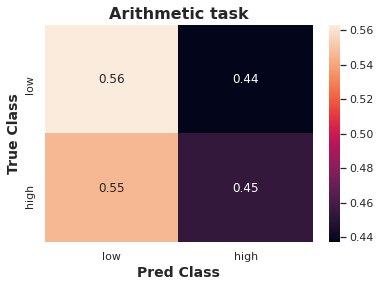

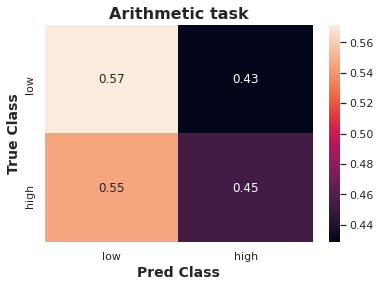

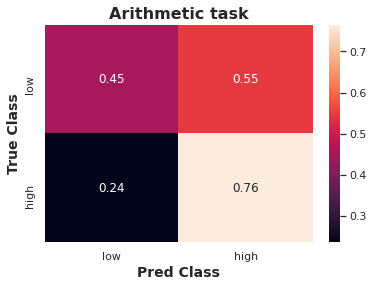

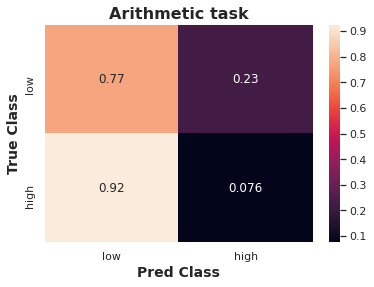

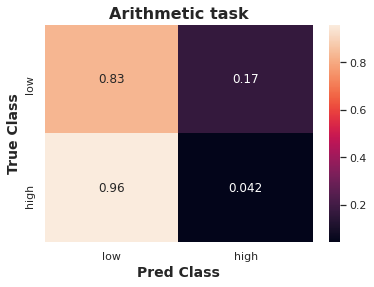

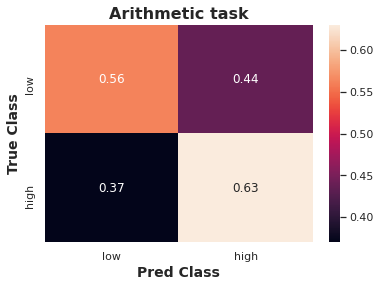

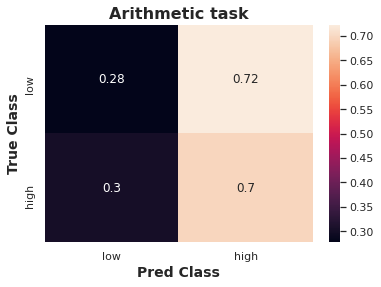

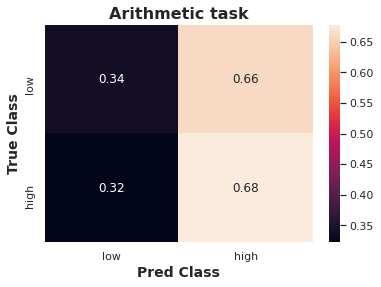

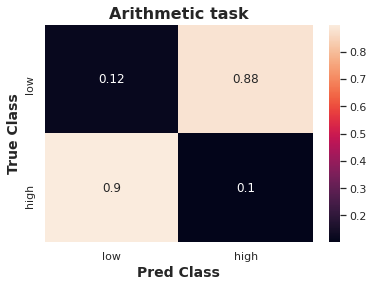

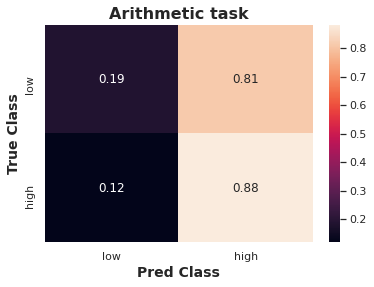

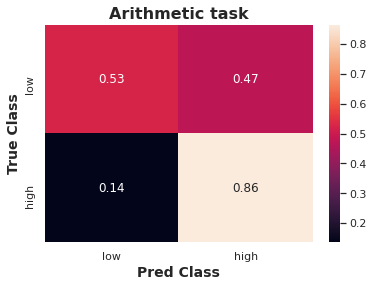

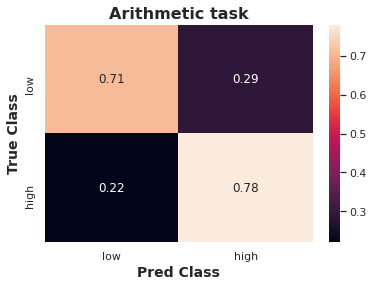

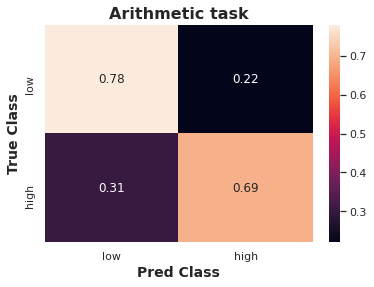

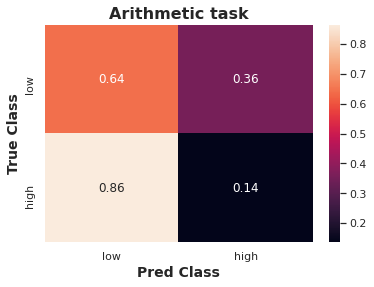

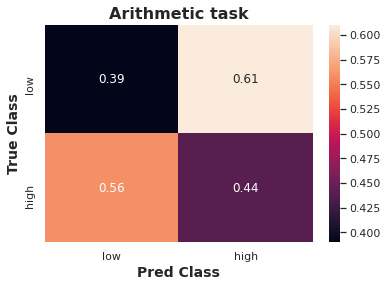

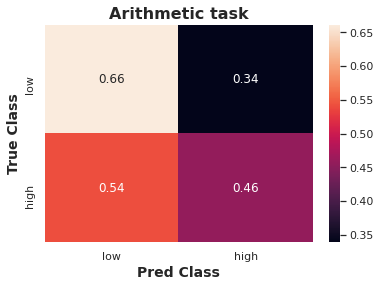

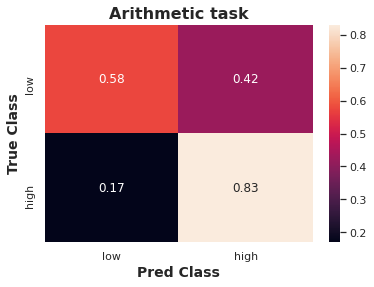

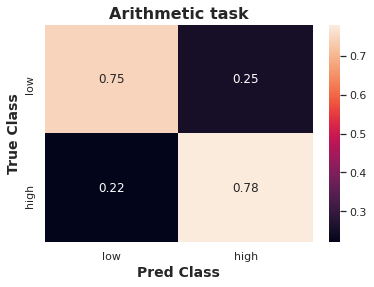

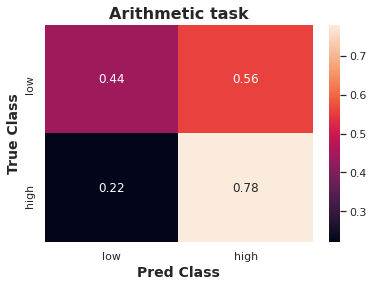

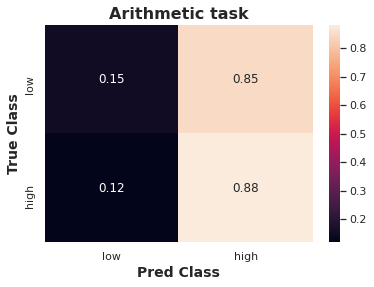

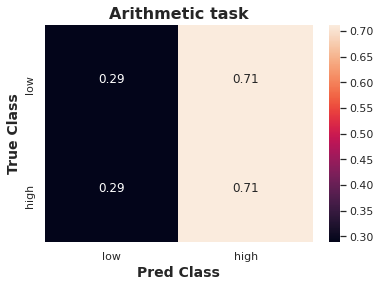

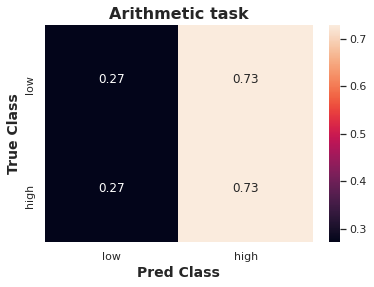

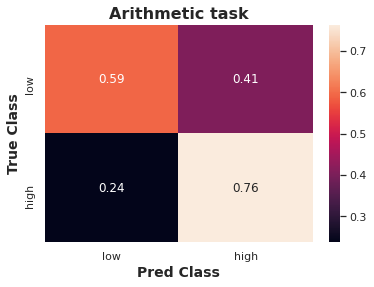

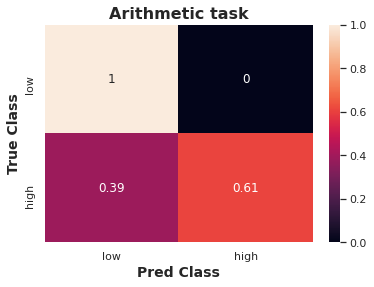

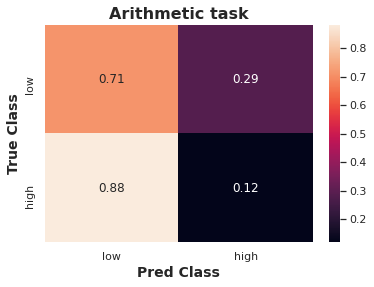

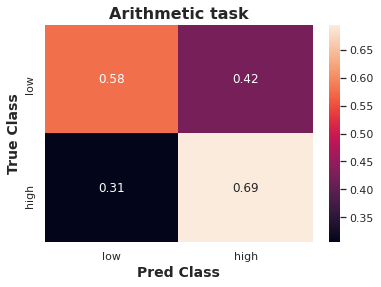

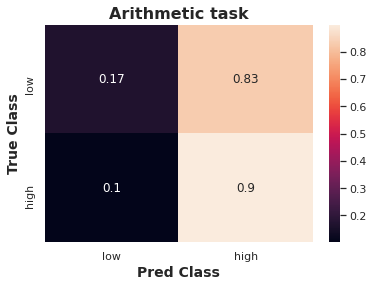

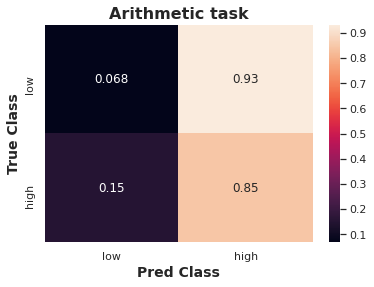

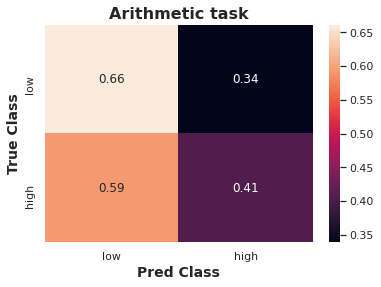

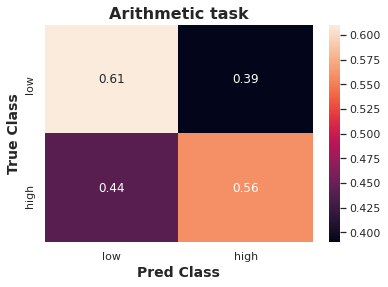

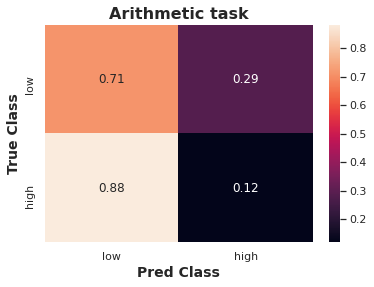

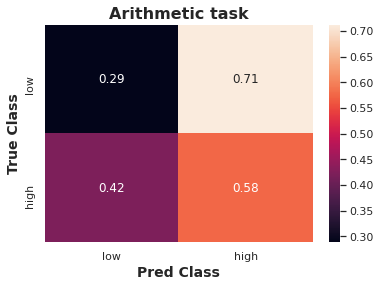

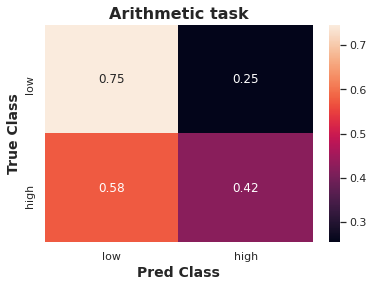

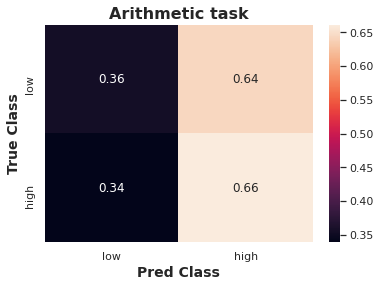

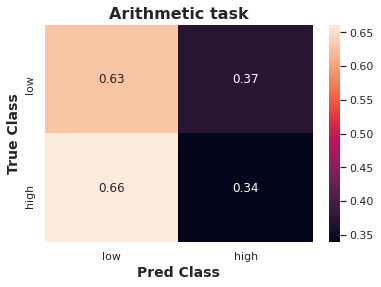

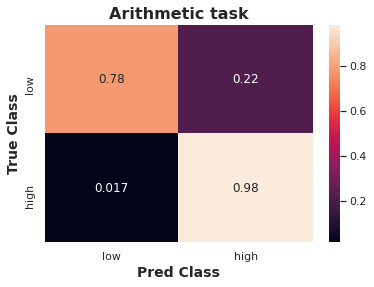

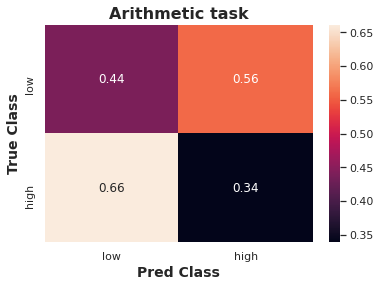

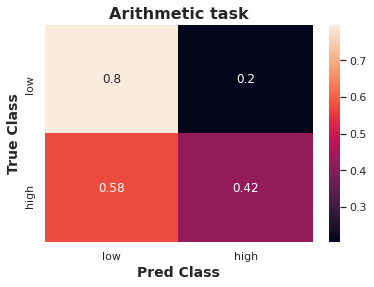

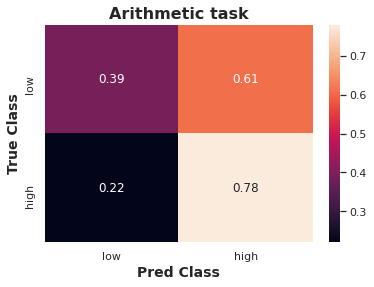

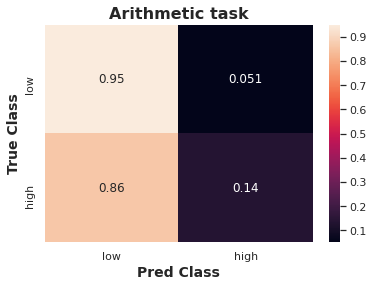

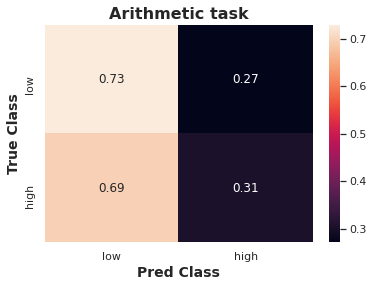

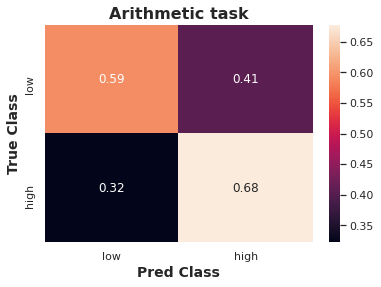

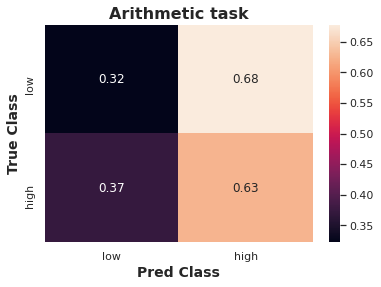

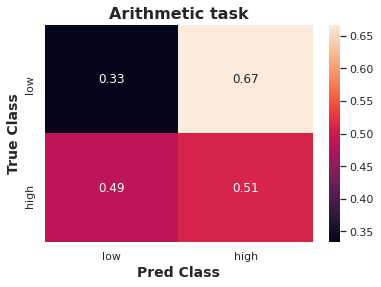

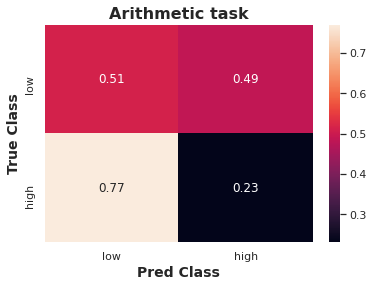

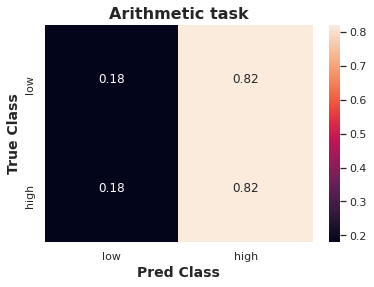

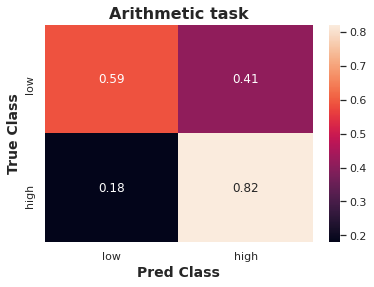

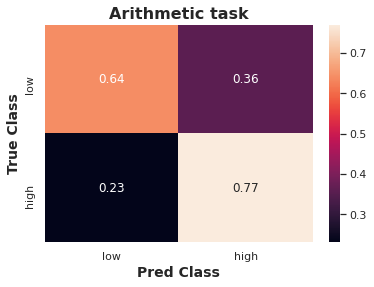

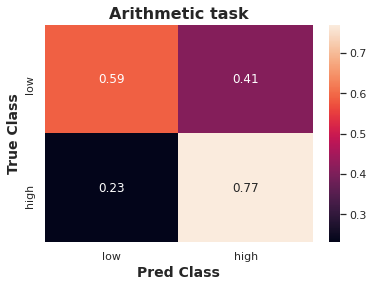

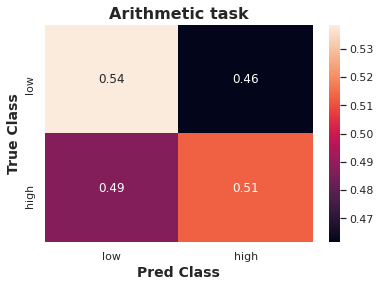

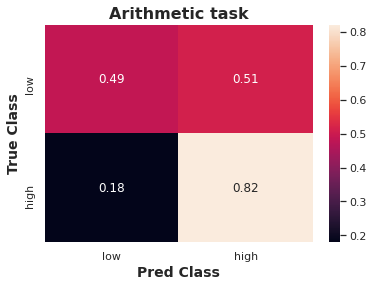

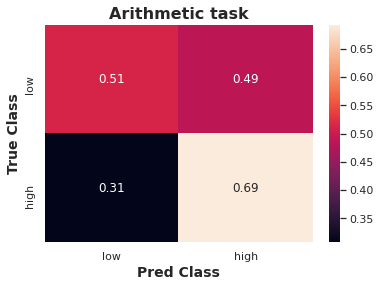

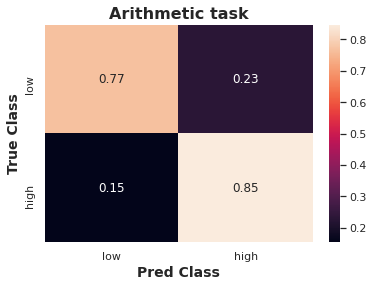

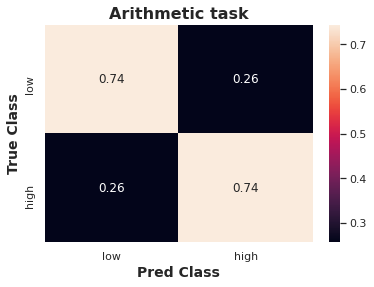

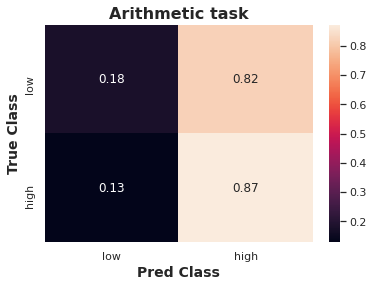

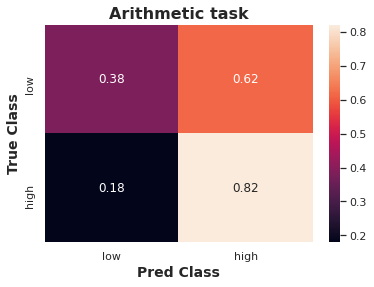

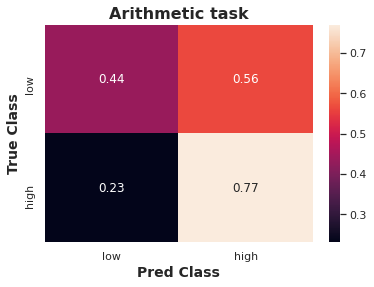

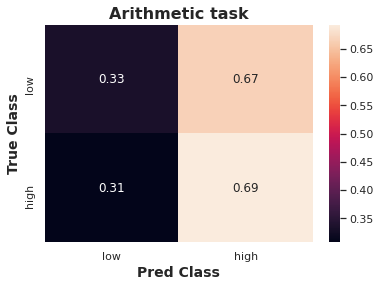

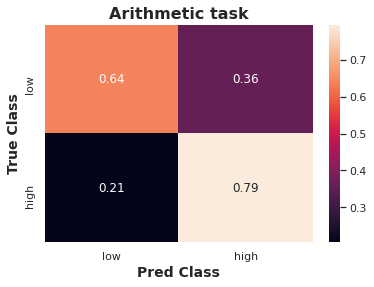

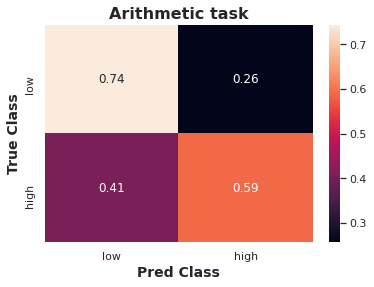

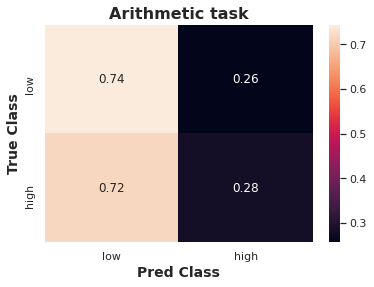

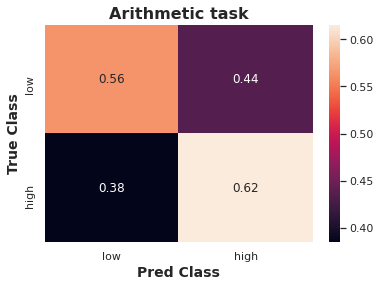

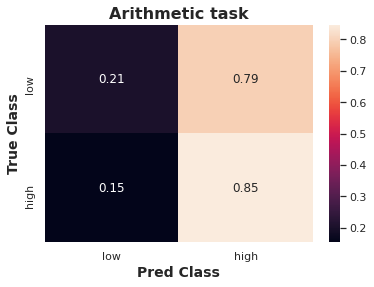

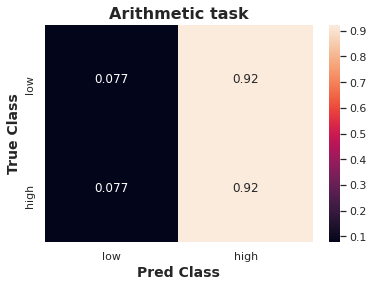

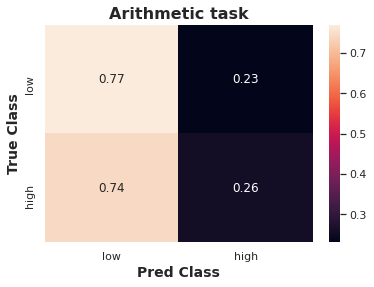

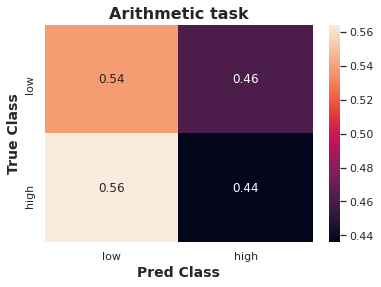

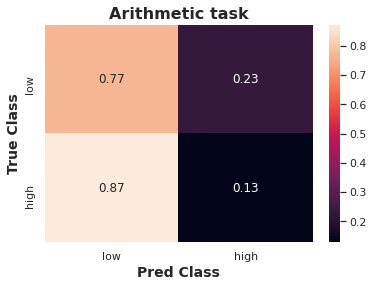

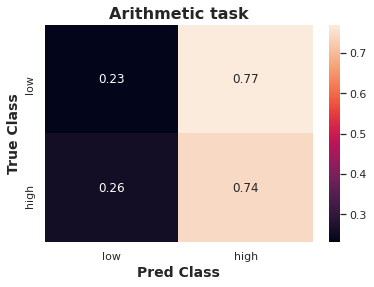

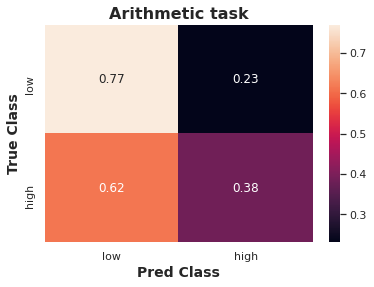

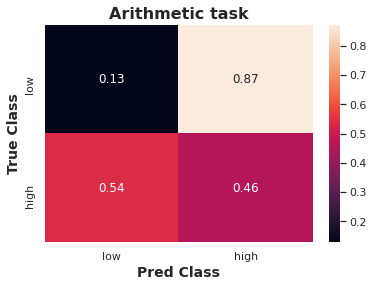

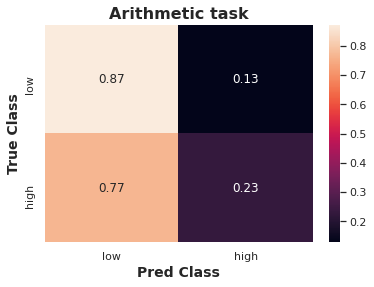

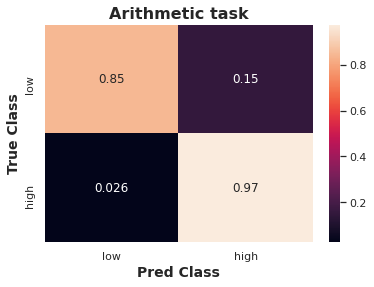

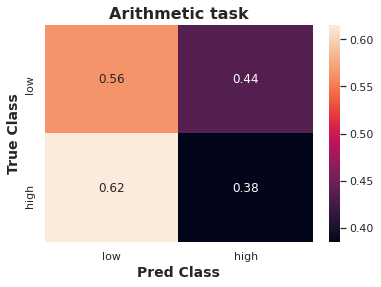

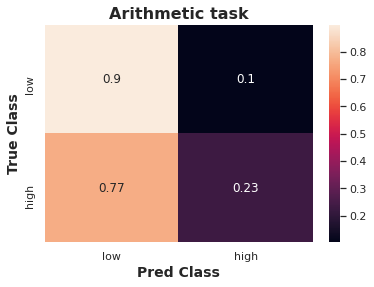

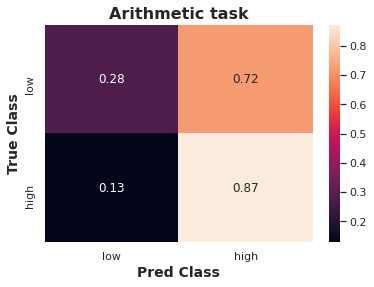

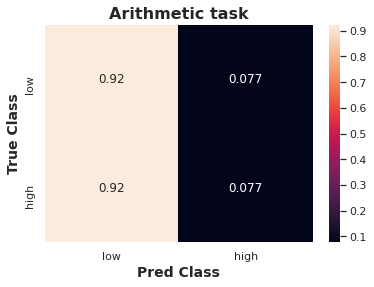

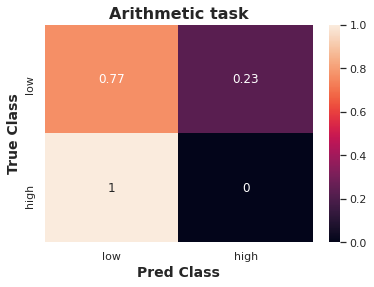

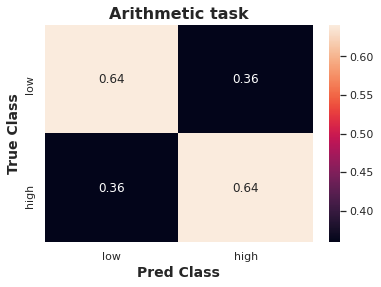

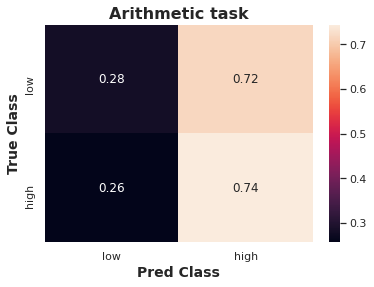

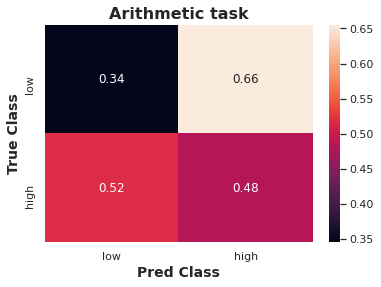

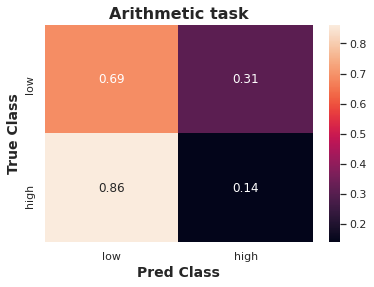

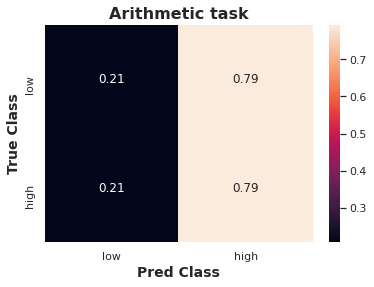

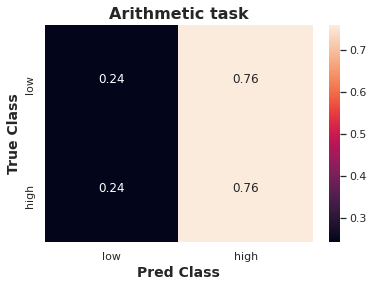

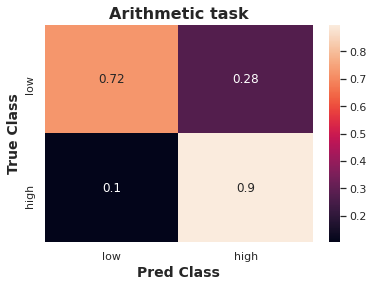

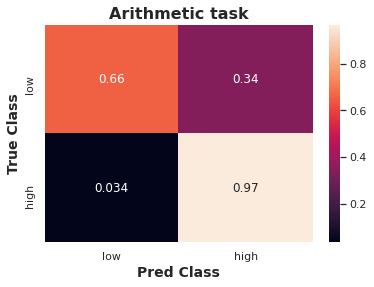

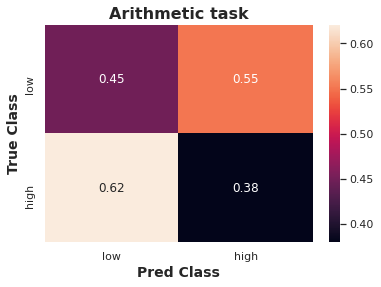

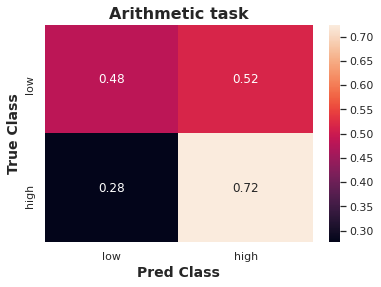

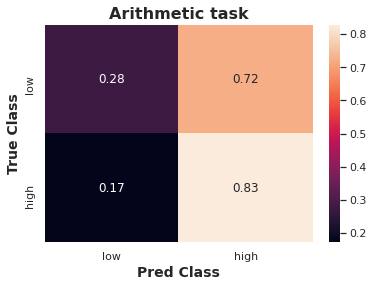

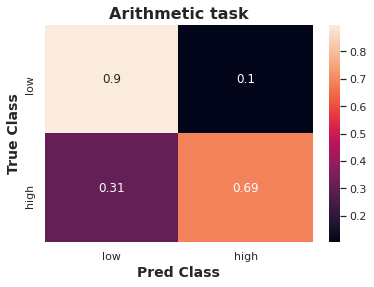

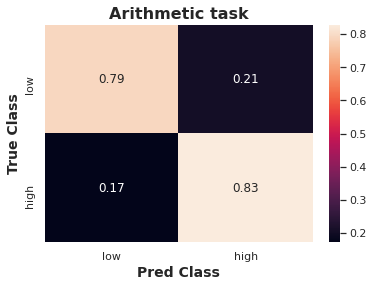

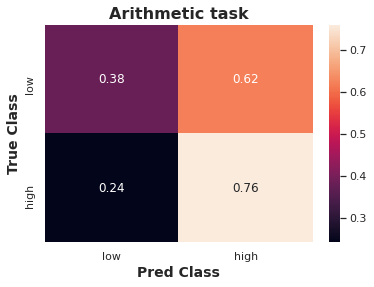

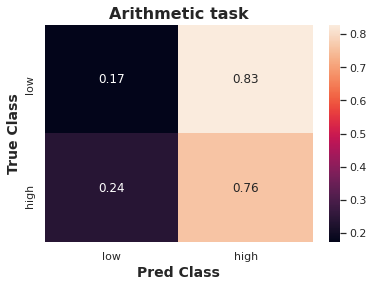

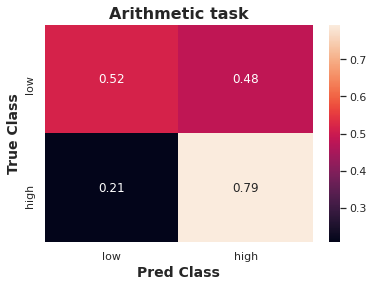

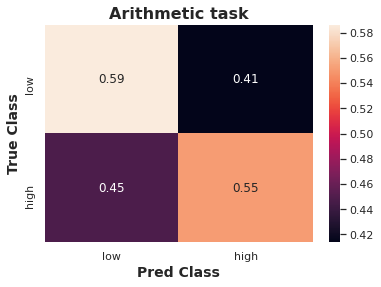

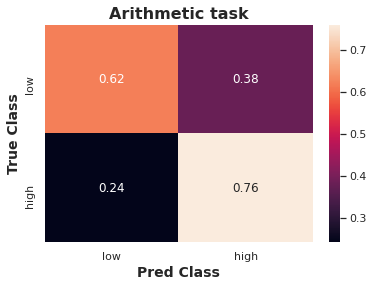

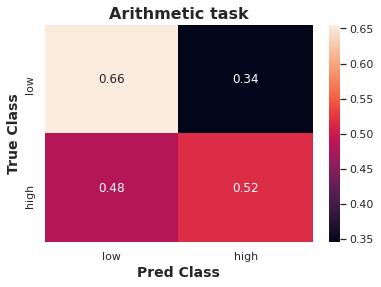

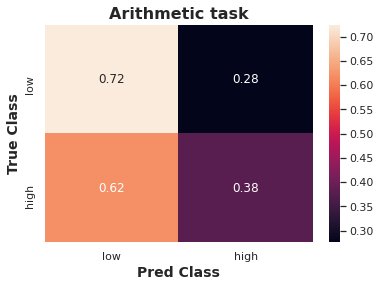

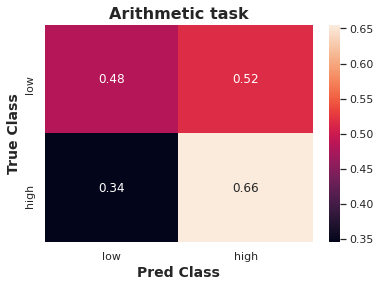

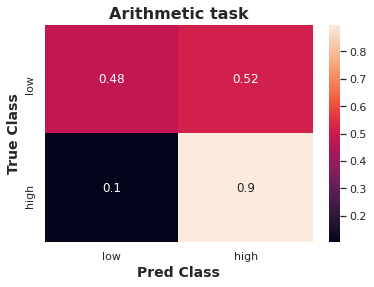

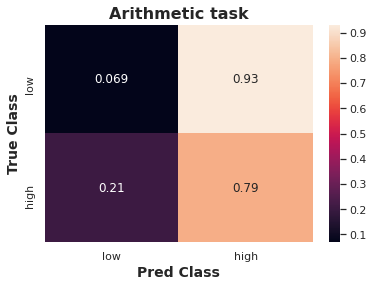

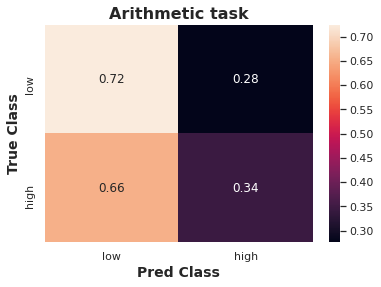

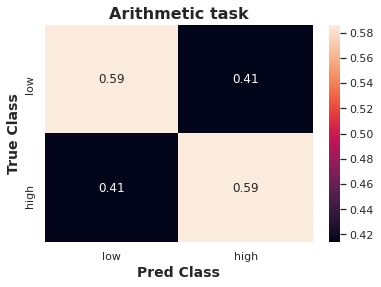

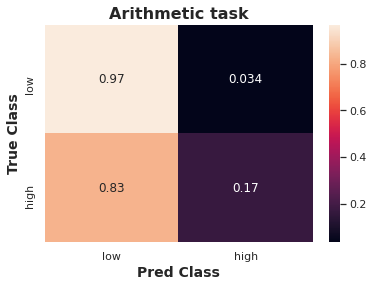

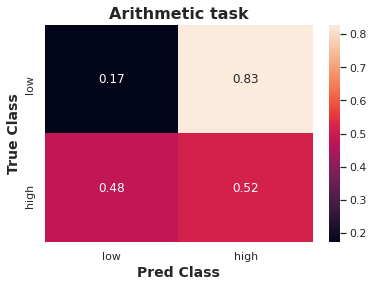

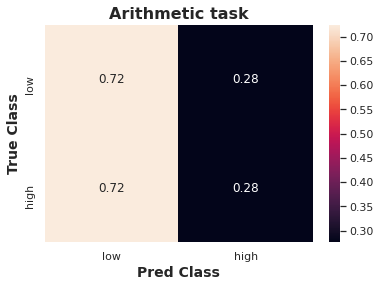

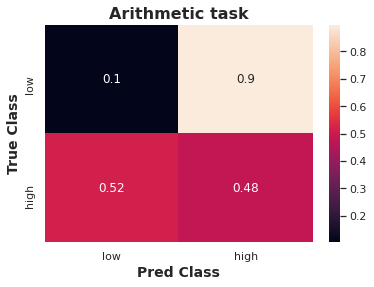

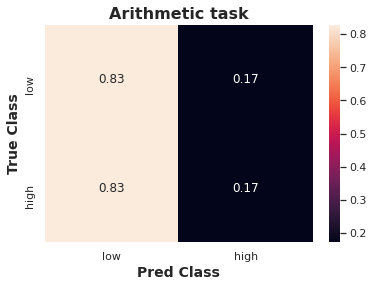

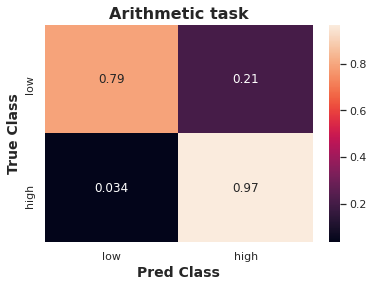

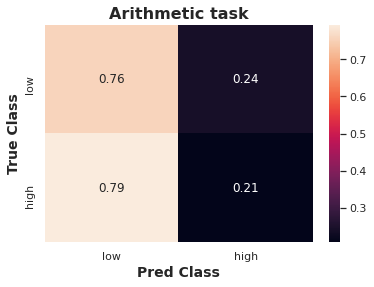

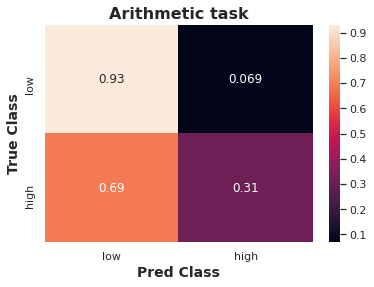

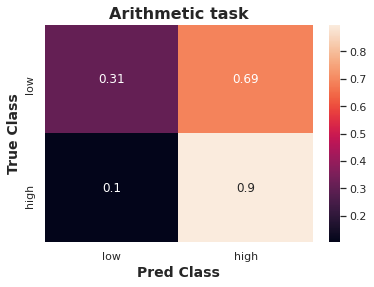

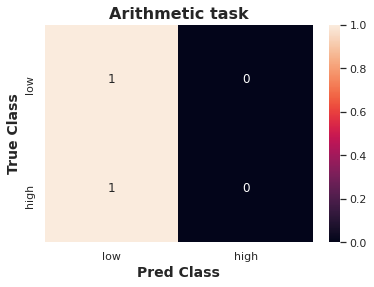

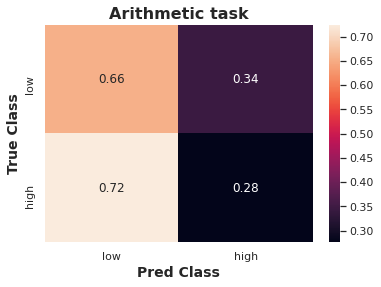

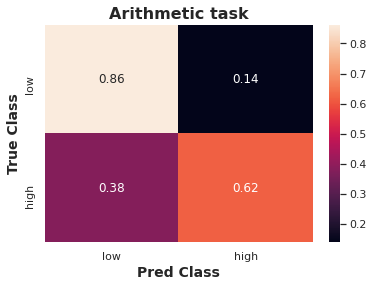

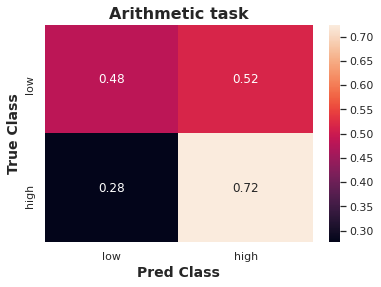

In [361]:
for sw in range(1, 5):
    update_sample(sliding_win=sw, stride=sw/2)
    DMAC_LOSO(sw)

# QMAC

## 这个任务指 对MAC任务的质量评估，Q：Quality. 
### 在该任务中，没有所谓的LOSO和INTRA任务了，只选取status_id==2（测试时）数据集
### GOOD：26个对象，BAD有10个对象
### 随机从GOOD中选择10个对象，与BAD构成类平衡数据集，然后进行5-fold
### 重复上述过程20次

In [17]:
import random

In [18]:
quality = np.loadtxt(os.path.join(dataset_dir, "subject-info.csv"), dtype=int, usecols=[5], skiprows=1, delimiter=",")
subject = np.loadtxt(os.path.join(dataset_dir, "subject-info.csv"), dtype=object, usecols=[0], skiprows=1, delimiter=",")
GOOD_file_list = list(np.reshape(subject[np.argwhere(quality==1)], -1))
BAD_file_list = list(np.reshape(subject[np.argwhere(quality==0)], -1))

In [19]:
GOOD_file_list

['Subject01',
 'Subject02',
 'Subject03',
 'Subject05',
 'Subject07',
 'Subject08',
 'Subject11',
 'Subject12',
 'Subject13',
 'Subject15',
 'Subject16',
 'Subject17',
 'Subject18',
 'Subject20',
 'Subject23',
 'Subject24',
 'Subject25',
 'Subject26',
 'Subject27',
 'Subject28',
 'Subject29',
 'Subject31',
 'Subject32',
 'Subject33',
 'Subject34',
 'Subject35']

In [20]:
def update_sample(sliding_win=1, stride=0.5):
    # 为test提取特征
    print(f"滑动窗口{sliding_win}s, 步长{stride}s")
    for sub_id, status_id, data in next_subject_data(status=2):
        gen_feature(data, "DMAC/test", sub_id, sliding_win, stride)

In [22]:
def quality_evaluation(sw=1):
    def get_samplt(fname):
        fname = str(fname).strip()
        sub_id = int(fname[-2:])
        fea_fname = "S_{}.pkl".format(sub_id)
        with open(os.path.join(os.path.join(feature_dir, "DMAC/test"), fea_fname), "rb") as pkl_file:
            test_sample = pickle.load(pkl_file) 
            
            return test_sample
    
    GOOD_file_list = list(np.reshape(subject[np.argwhere(quality==1)], -1))
    BAD_file_list = list(np.reshape(subject[np.argwhere(quality==0)], -1))
    
    # 此处是为了将数据分组，避免随机K-FOLD时，导致一部分数据在训练集中泄露
    G_sample = get_samplt(GOOD_file_list[0])
    n_samples = G_sample.shape[0]
    groups = np.zeros(n_samples)
    groups[:int(n_samples/5)] = 1
    groups[int(n_samples/5):int(n_samples*2/5)] = 2
    groups[int(n_samples*2/5):int(n_samples*3/5)] = 3
    groups[int(n_samples*3/5):int(n_samples*4/5)] = 4
    groups[int(n_samples*4/5):] = 5
    groups = np.tile(groups, 2)

    groups = np.tile(groups, len(BAD_file_list))
   
    for rid in range(10,30):
        # 重复进行20次，每次进行一个5-fold
        # 每次都重新选择good集
        clf = RF()
        #clf = LR()
        #clf = KNN(n_jobs=-1)
        #clf = MLP()
        random.seed(rid)
        #从样本中随机选取和bad数量相同的样本
        GOOD_file_list = random.sample(GOOD_file_list, len(BAD_file_list))
        # 依次提取正反例样本
        sample = np.zeros((0,200))
        label = [] 
        for G_fname,B_fname in zip(GOOD_file_list, BAD_file_list):
            G_sample = get_samplt(G_fname)
            B_sample = get_samplt(B_fname)
            sample = np.concatenate((sample, G_sample), axis=0)
            label += [1] * G_sample.shape[0]
            sample = np.concatenate((sample, B_sample), axis=0)
            label += [0] * B_sample.shape[0]
        label = np.array(label)
        print("第{}次随机，数据集大小 sample: {}, label: {}".format(rid, sample.shape, label.shape))
        print(sample.shape, label.shape, groups.shape)
        start = time()
        Kfold_validation(clf, sample, label,groups, sw=sw, task="binary", sub=rid, path="RF/QMAC/mixed", show_cm=0, repeats=1)
        end = time()
        print(f"{rid}: {round((end-start), 4)}s")

In [23]:
for sw in range(1, 5):
    update_sample(sliding_win=sw, stride=sw/2)
    quality_evaluation(sw)

滑动窗口1s, 步长0.5s
Extracting EDF parameters from /home/data1/maliang/EEG_related/MAC/MAC_Dataset/physionet.org/files/eegmat/1.0.0/Subject00_2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /home/data1/maliang/EEG_related/MAC/MAC_Dataset/physionet.org/files/eegmat/1.0.0/Subject01_2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /home/data1/maliang/EEG_related/MAC/MAC_Dataset/physionet.org/files/eegmat/1.0.0/Subject02_2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /home/data1/maliang/EEG_related/MAC/MAC_Dataset/physionet.org/files/eegmat/1.0.0/Subject03_2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /home/data1/maliang/EEG_related/MAC/MAC_Dataset/physionet.org/files/eegmat/1.0.0/Subject04_2.edf..

In [190]:
label = []

In [191]:
label += [1]*10

In [192]:
label += [0] *10

In [193]:
label

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]